In [101]:
import pandas as pd
import os
import json
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [102]:
kk = 95

In [143]:
data = "output/timeQueries/influx/"
names = os.listdir(os.path.join(data))
#names.remove('.DS_Store')
runs = list(np.sort(os.listdir(os.path.join(data, names[0]))))
#runs.remove('.DS_Store')
results = ["ttiM4Results", "ttiMinMaxResults", "m4Results"]
data, results, runs, names

('output/timeQueries/influx/',
 ['ttiM4Results', 'ttiMinMaxResults', 'm4Results'],
 ['run_0'],
 ['intel_lab_exp'])

In [144]:
results_paths = [os.path.join(data, name, run, result) for result in results for run in runs for name in names ]

In [145]:
dcts = [{
    'IO Count': 'mean',
    'Time (sec)': 'mean',
    'Memory': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'from': 'mean',
    'to': 'mean',
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Error': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
},
    {
    'IO Count': 'mean',
    'Time (sec)': 'mean',
    'Memory': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'from': 'mean',
    'to': 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
},
    
    {
    'Time (sec)': 'mean',
    'query #': 'mean',
    'width' : 'mean',
    'height' : 'mean',
    'from': 'mean',
    'to': 'mean',
    'timeRange': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'Results size': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'dataset': lambda col: col.mode() if col.nunique() == 1 else np.nan,
    'operation': lambda col: col.mode() if col.nunique() == 1 else np.nan
}]

dfs_all = [pd.read_csv(os.path.join(df, "results.csv")) for df in results_paths]
dfs = []
for i in range(0, len(dfs_all), len(runs)):
    dds = dfs_all[i : i + len(runs)]
    d = dds[0]
    if(len(runs) > 1):
        for j in range(1, len(runs)):
            d = pd.concat((d, dds[j]))
        d = d.groupby(d.index).agg(**{k: (k, v) for k, v in dcts[i // len(runs)].items()})
    dfs.append(d)

In [146]:
def plot_time(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 4, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 3, 1, 1]})
    fig.suptitle(f"Time, IO and average time in {name} dataset")
    axs[0].plot(dfs[0]["Time (sec)"], label= "VS Cache M4")
    axs[0].plot(dfs[1]["Time (sec)"], label="Vs Cache Min Max")
    axs[0].plot(dfs[2]["Time (sec)"], label="Μ4")
        
    axs[1].plot(dfs[0]["IO Count"], label= "VS Cache M4")
    axs[1].plot(dfs[1]["IO Count"], label= "Vs Cache Min Max")

    axs[2].bar(0, dfs[0]["Time (sec)"].mean())
    axs[2].bar(1, dfs[1]["Time (sec)"].mean())
    axs[2].bar(2, dfs[2]["Time (sec)"].mean())
    axs[2].set_xticklabels([])
    
    axs[3].bar(0, dfs[0]["Time (sec)"].sum())
    axs[3].bar(1, dfs[1]["Time (sec)"].sum())
    axs[3].bar(2, dfs[2]["Time (sec)"].sum())
    axs[3].set_xticklabels([])
    
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE M4", "VS Cache Min Max", "Μ4"])
    plt.savefig(f"times/kk={kk}.png")
    plt.show()
    # times_df = pd.DataFrame({"tti": dfs[0]["Time (sec)"],"m4": dfs[2]["Time (sec)"]})
    # times_df.to_csv("times/kk=5.csv")

def plot_memory(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Memory and average memory in {name} dataset")
    i = 0
    axs[0].plot(dfs[0]["Memory"], label= "VS Cache M4")
    axs[0].plot(dfs[1]["Memory"], label="RAW Cache Min Max")

    axs[1].bar(0, dfs[0]["Memory"].mean())
    axs[1].bar(1, dfs[1]["Memory"].mean())
    axs[1].set_xticklabels([])
    i+=1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS Cache", "RAW Cache"])
    plt.show()
    
def plot_compaction(dfs, name):
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [3, 1]})
    fig.suptitle(f"Data Compaction in {name} dataset")
    i = 0
    dfs[0]["TTI compaction"] = dfs[0]["Results size"]/dfs[1]["Results size"]
    dfs[2]["InfluxDB compaction"] = dfs[2]["Results size"]/dfs[1]["Results size"]

    axs[0].plot(dfs[0]["TTI compaction"], label= "VS Cache")
    axs[0].plot(dfs[2]["InfluxDB compaction"], label="Μ4")

    axs[1].bar(0, dfs[0]["TTI compaction"].mean())
    axs[1].bar(1, dfs[2]["InfluxDB compaction"].mean())
    axs[1].set_xticklabels([])
    i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS CACHE", "RAW Cache"])

    plt.show()
    
def plot_time_per_operation(dfs, name):
    plt.clf()
    width = 0.3
    i = 0
    fig, axs = plt.subplots(1, 1, figsize=(10, 8))
    fig.suptitle(f"Average time per operation in {name} dataset")

    tti = (dfs[0][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    raw = (dfs[1][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    psql = (dfs[2][["operation", "Time (sec)"]].groupby("operation").aggregate('mean'))
    r = np.arange(3)
    axs.bar(r, tti['Time (sec)'], width=width, label="VS Cache")
    axs.bar(r + width, raw['Time (sec)'],  width=width, label= "RAW Cache")
    axs.bar(r + 2*width, psql['Time (sec)'], width=width,  label = "Μ4")
    axs.set_xticks(r + width, ['PAN', 'ZI', 'ZO'])
    i+= 1
    fig.legend(loc=2, bbox_to_anchor=(0.9, 0.6), labels=["VS Cache", "RAW Cache", "Μ4"])

    plt.show()

<Figure size 640x480 with 0 Axes>

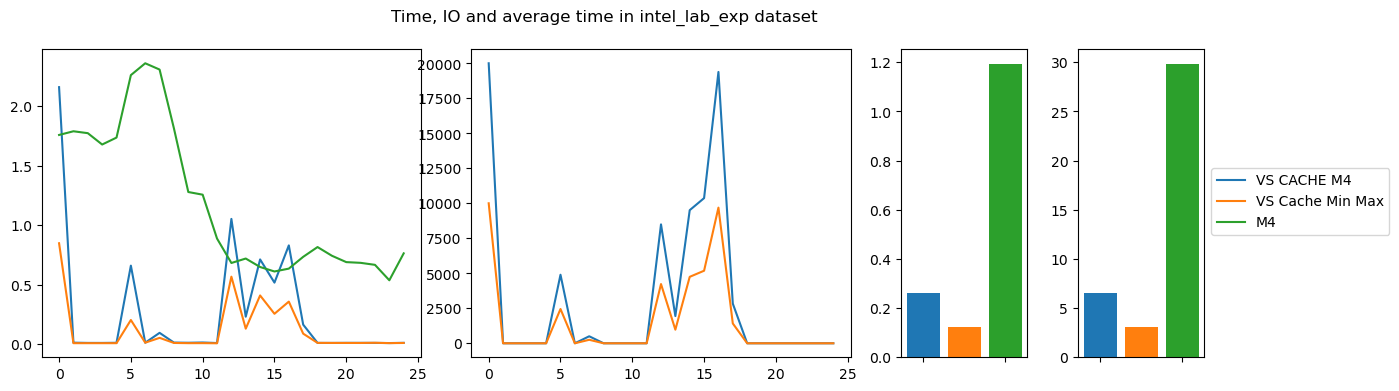

In [147]:
j = 0
for i in range(0, len(dfs), 3):
    plot_time(dfs[i : i + 3], names[i])

In [148]:
from skimage import io, color
from skimage.metrics import structural_similarity as compare_ssim
import cairo

def plot(df, measure, name, width, height, queryFrom, queryTo):
    # Define the surface and the context
    surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, width, height)
    ctx = cairo.Context(surface)
    
    ctx.set_antialias(cairo.Antialias.NONE)
    
    # Clear the background (white)
    ctx.set_source_rgb(1, 1, 1)
    ctx.paint()
    
    # Transform coordinate system so that (0,0) is the bottom left
    ctx.translate(0, height)
    ctx.scale(1, -1)
    
    # Plot the line (black)
    ctx.set_source_rgb(0, 0, 0)  # color
    ctx.set_line_width(1)  # line width
    
    pixelInterval = (queryTo - queryFrom) // width
    
    # Move to the first point
    ctx.move_to(
        np.floor((df['timestamp'].iloc[0] - queryFrom) / pixelInterval), 
        np.floor(height * ((df[measure].iloc[0] - df[measure].min()) / (df[measure].max() - df[measure].min())))
    )

    # Add lines to subsequent points
    for i in range(1, len(df)):
        ctx.line_to(
            np.floor((df['timestamp'].iloc[i] - queryFrom) / pixelInterval), 
            np.floor(height * ((df[measure].iloc[i] - df[measure].min()) / (df[measure].max() - df[measure].min())))
        )

    ctx.stroke()  # Apply the stroke
    
    # Save to a file
    surface.write_to_png(name + '.png')

    
    
def calculate_ssim(image_file1, image_file2, width, height):
    # Read the two images
    image1 = io.imread(image_file1)
    image2 = io.imread(image_file2)
    # Remove the alpha channel if present
    if image1.shape[2] == 4:
        image1 = image1[:, :, :3]
    if image2.shape[2] == 4:
        image2 = image2[:, :, :3]
    
    image1_gray = color.rgb2gray(image1)
    image2_gray = color.rgb2gray(image2)
    
    (score, _) = compare_ssim(image1_gray, image2_gray, full=True)
    # print(f"SSIM between {image_file1} and {image_file2}: {ssim_index:.4f}")
    diff = image1_gray - image2_gray
    # Search for all pixels that are different 
    # Type is <class 'numpy.ndarray'>, you can optionally convert to a list
    coords = np.argwhere(diff != 0)
    coords = coords.tolist() 
    return score, len(coords)/(width*height)


def get_mean_error(s, measures):
    a = (s.split("="))
    errs = []
    for l in a:
        if ("," in l):
            errs.append(float(l.split(",")[0]))
    errs.append(float(a[-1].split(",")[0][:-1]))
    return np.mean(errs)
    
    
def plot_indexes(df1, df2, name):

    fig, axs = plt.subplots(1, 1, figsize=(10, 8))

    tti_path1 = os.path.join(data, name, "run_0", "ttiM4Results")
    tti_path2 = os.path.join(data, name, "run_0", "ttiMinMaxResults")
    
    raw_path = os.path.join(data, name, "run_0", "rawResults")
    m4_path = os.path.join(data, name, "run_0", "m4Results")

    tti_query_0 = os.path.join(data, name, "run_0", "ttiM4Results", "query_0")
    sql_query_0 = os.path.join(data, name, "run_0", "m4Results", "query_0")

    meassure_files = os.listdir(tti_query_0)
    measures = [x.replace(".csv", "") for x in meassure_files]
    queries = os.listdir(results_paths[0])
    all_ssim = [] 
    all_diffs = [] 
    errors = []
    errors1 = df1['Error'].apply(get_mean_error, args=([measures]))
    errors2 = df2['Error'].apply(get_mean_error, args=([measures]))

    for i in range(len(df1)):
        q = f"query_{i}"
        j = 0
        ssim1 = 0
        ssim2 = 0
        diffs1 = 0
        diffs2 = 0
        for m in meassure_files:
            path_tti1 = os.path.join(tti_path1, q)
            path_tti2 = os.path.join(tti_path2, q)
            
            path_raw = os.path.join(raw_path, q)
            path_sql = os.path.join(m4_path, q)
            df_tti1 = pd.read_csv(os.path.join(path_tti1, m))
            df_tti2 = pd.read_csv(os.path.join(path_tti2, m))
            df_m4 = pd.read_csv(os.path.join(path_sql, m))
            #df_raw = pd.read_csv(os.path.join(path_raw, m))
            width = int(df1['width'][0])
            height = int(df1['height'][0])
            queryFrom = int(df1['from'][i])
            queryTo = int(df1['to'][i])
            plot(df_tti1, measures[j], f"plots/{q}-{measures[j]}-tti1",width,height, queryFrom, queryTo)
            plot(df_tti2, measures[j], f"plots/{q}-{measures[j]}-tti2",width,height, queryFrom, queryTo)   
            plot(df_m4, measures[j], f"plots/{q}-{measures[j]}-m4", width, height, queryFrom, queryTo)
            score1, diff1 = calculate_ssim(f"plots/{q}-{measures[j]}-tti1.png", f"plots/{q}-{measures[j]}-m4.png", width, height)
            score2, diff2 = calculate_ssim(f"plots/{q}-{measures[j]}-tti2.png", f"plots/{q}-{measures[j]}-m4.png", width, height)
            #print(f"SSIM for query {i}: {score} {diff}")
            ssim1 += score1
            ssim2 += score2
            diffs1 += diff1
            diffs2 += diff2
            # os.remove("tti.png")
            # os.remove("raw.png")
            j+=1  
        avg_ssim1 = ssim1 / len(measures)
        avg_ssim2 = ssim2 / len(measures)
        avg_diff1 = diffs1 / len(measures)
        avg_diff2 = diffs2 / len(measures)
        all_ssim.append([avg_ssim1, avg_ssim2])
        all_diffs.append([avg_diff1, avg_diff2])
    fig.suptitle(f"SSIM in {name} dataset.")
    axs.plot(all_ssim, label=[f"SSIM M4", f"SSIM Min Max"])
    axs.plot(errors1, label=f"MAX ERROR M4")
    axs.plot(errors2, label=f"MAX ERROR Min Max")
    # for i in range(len(df1)):
    #     if(df1['flag'][i] == True):
    #         axs.scatter(i, 1, color='red')
    # for i in range(len(df2)):
    #     if(df2['flag'][i] == True):
    #         axs.scatter(i, 0.95, color='blue')
    # Set x-axis ticks
    axs.set_xticks(range(len(df1)))
    # Set x-axis tick labels as 'query_{q}'
    axs.set_xticklabels([f'{i}:{dfs_all[0].operation[i]}' for i in range(len(df1))], rotation=45)
#     axs.set_xticks([0,5,10,15,20,25,30,35,40,45,50])
    axs.plot(all_diffs, label=[f"Difference M4", f"Difference Min Max"])
    axs.legend()
    plt.savefig(f"ssims/kk={kk}")
    plt.show()   

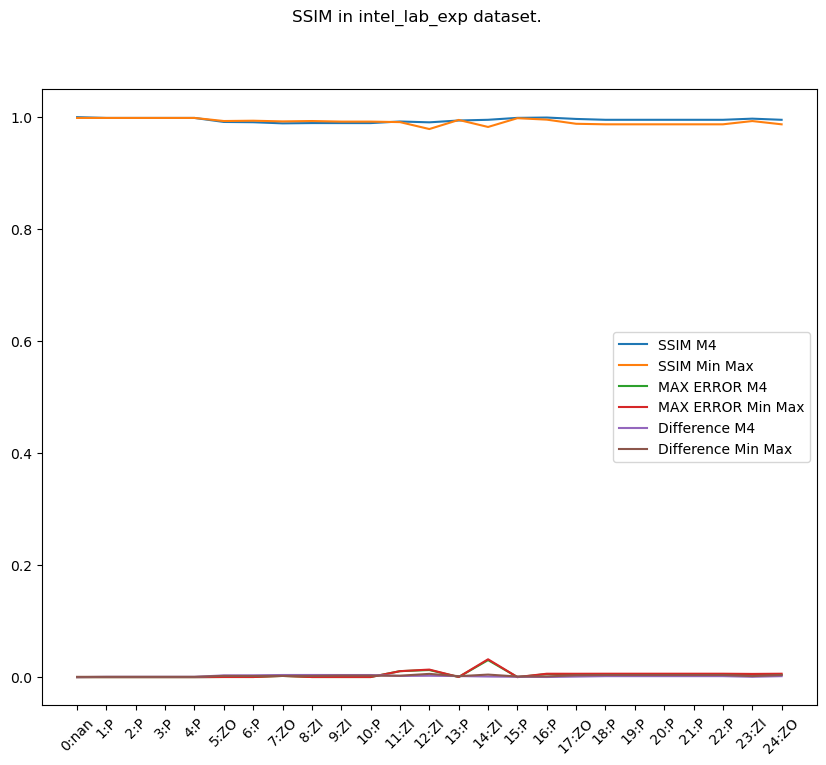

In [149]:
for i in range(0, len(dfs), 3):
    plot_indexes(dfs[0], dfs[1], names[i])